# NOTE

The Trackman data is confidential, so the data used in this script is only to show the main methods used.

The data is simulated using the create_sim_data.ipynb script.

For this script only the ResNet architecture is used, but all models have been trained similarly.

The results are not representative of the actual results using the real dataset.

# Load data

In [4]:
from pathlib import Path

from numpy import log10
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from custom_transforms import LoadSpectrogram, ToTensor
from data_management import make_dataset_name
from models import weights_init_uniform_rule, ResNet

# from modular_train_test import train_one_epoch

MODEL = ResNet
LEARNING_RATE = 10**(-3.46)
WEIGHT_DECAY = 10**(-5.39)
# EPOCHS = 300 # Normally set to 300 for the real data
BATCH_SIZE = 16
NUM_WORKERS = 0
OPTIMIZER = torch.optim.Adam
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Paths
DATA_ROOT = Path("../data")
STMF_FILENAME = "stmf_data_3.csv"
train_dir = DATA_ROOT / "train"
validation_dir = DATA_ROOT / "validation"

# Transforms
TRAIN_TRANSFORM = Compose([
    LoadSpectrogram(root_dir=train_dir),
    ToTensor(),
])

VALIDATION_TRANSFORM = Compose([
    LoadSpectrogram(root_dir=validation_dir),
    ToTensor(),
])

train_dataset = MODEL.dataset(data_dir= DATA_ROOT / "train",
                        stmf_data_path = DATA_ROOT / STMF_FILENAME,
                        transform=TRAIN_TRANSFORM)

validation_dataset = MODEL.dataset(data_dir= DATA_ROOT / "validation",
                        stmf_data_path = DATA_ROOT / STMF_FILENAME,
                        transform=VALIDATION_TRANSFORM)

train_data_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=10, shuffle=False, num_workers=NUM_WORKERS)

# Test the dataloaders
for batch in train_data_loader:
    print(batch["spectrogram"].shape)
    print(batch["target"].shape)
    break

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(validation_dataset)}")


torch.Size([16, 6, 74, 918])
torch.Size([16])
Training set size: 300
Validation set size: 100


# Set up model

In [5]:
model = MODEL().to(DEVICE)
model.apply(weights_init_uniform_rule)

optimizer = OPTIMIZER(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [6]:
def train_one_epoch(loss_fn, model, train_data_loader):
    running_loss = 0.
    last_loss = 0.
    total_loss = 0.

    for i, data in enumerate(train_data_loader):

        spectrogram, target = data["spectrogram"].to(DEVICE), data["target"].to(DEVICE)
        
        optimizer.zero_grad()

        outputs = model(spectrogram)

        loss = loss_fn(outputs.squeeze(), target)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        total_loss += loss.item()
        if i % train_data_loader.batch_size == train_data_loader.batch_size - 1:
            last_loss = running_loss / train_data_loader.batch_size # loss per batch
            # print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return total_loss / (i+1)

# Perform training

In [7]:
out_dict = {
        "loss": [],
        "rmse": [],
        "log_rmse": [],
        "test_loss": [],
        "test_rmse": [],
        "log_test_rmse": [],
    }

EPOCHS = 50
epoch_number = 0
best_vloss = 10000
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)

    # Do a pass over the training data and get the average training MSE loss
    avg_loss = train_one_epoch(MODEL.loss_fn, model, train_data_loader)
    
    rmse = avg_loss**(1/2)

    log_rmse = log10(rmse)

    running_test_loss = 0.

    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(validation_data_loader):
      
            spectrogram, target = vdata["spectrogram"].to(DEVICE), vdata["target"].to(DEVICE)  # Use only the 5th channel, keep channel dimension
            
            test_outputs = model(spectrogram)

            test_loss = MODEL.loss_fn(test_outputs.squeeze(), target)

            running_test_loss += test_loss

    avg_test_loss = running_test_loss / (i + 1)

    test_rmse = avg_test_loss**(1/2)

    log_test_rmse = torch.log10(test_rmse)

    print('LOSS train {} ; LOSS validation {}'.format(avg_loss, avg_test_loss))
    
    out_dict['loss'].append(avg_loss)
    out_dict['rmse'].append(rmse)
    out_dict['log_rmse'].append(log_rmse)
    out_dict['test_loss'].append(test_loss.item())
    out_dict['test_rmse'].append(test_rmse.item())
    out_dict['log_test_rmse'].append(log_test_rmse.item())
    # Track best performance, and save the model's state
    if avg_test_loss < best_vloss:
        best_vloss = avg_test_loss
        # torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
LOSS train 471.802572350753 ; LOSS validation 15.866386413574219
EPOCH 2:
LOSS train 8.55353750053205 ; LOSS validation 4114.478515625
EPOCH 3:
LOSS train 1.5792673026260577 ; LOSS validation 26.95777702331543
EPOCH 4:
LOSS train 0.8482481005944704 ; LOSS validation 1.0494740009307861
EPOCH 5:
LOSS train 0.5438328203009931 ; LOSS validation 0.15168145298957825
EPOCH 6:
LOSS train 0.3510446591596854 ; LOSS validation 0.13832788169384003
EPOCH 7:
LOSS train 0.43488234673675735 ; LOSS validation 0.14177276194095612
EPOCH 8:
LOSS train 0.6077218800783157 ; LOSS validation 0.16998149454593658
EPOCH 9:
LOSS train 0.4277648055239728 ; LOSS validation 0.14225076138973236
EPOCH 10:
LOSS train 0.4971675998286197 ; LOSS validation 0.0866691917181015
EPOCH 11:
LOSS train 0.3115785596402068 ; LOSS validation 0.12681426107883453
EPOCH 12:
LOSS train 0.3307297386621174 ; LOSS validation 0.2823713421821594
EPOCH 13:
LOSS train 0.5398337252830204 ; LOSS validation 0.16059072315692902
EPOCH 14:

# Plot learning curves

Text(0, 0.5, 'RMSE [log]')

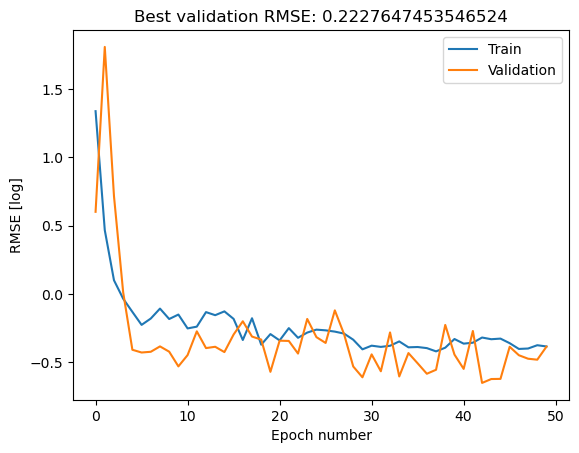

In [17]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(out_dict['log_rmse'], label='Train rmse')
plt.plot(out_dict['log_test_rmse'], label='Validation rmse')
plt.title(f'Best validation RMSE: {np.min(out_dict['test_rmse'])}')
plt.legend(('Train','Validation'))
plt.xlabel('Epoch number')
plt.ylabel('RMSE [log]')

# Testing the models and computing the residuals

In [18]:
test_dir = DATA_ROOT / "test"

TEST_TRANSFORM = Compose([
    LoadSpectrogram(root_dir=test_dir),
    ToTensor()
])

test_dataset = MODEL.dataset(data_dir= DATA_ROOT / "test",
                        stmf_data_path = DATA_ROOT / STMF_FILENAME,
                        transform=TEST_TRANSFORM)

test_data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)

In [19]:
total_residuals = []
running_loss = 0.0
total_samples = 0

model.eval()
with torch.no_grad():
    for batch_idx, data in enumerate(test_data_loader):
        spectrogram, target = data["spectrogram"].to(DEVICE), data["target"].to(DEVICE)

        outputs = model(spectrogram)
 
        residuals = outputs - target

        total_residuals.append(residuals)

        loss_fn = MODEL.loss_fn 
        loss = loss_fn(outputs.view(-1), target)

        running_loss += loss.item() * spectrogram.size(0)
        total_samples += spectrogram.size(0)

        rmse = torch.sqrt(loss)

# Calculate average loss over the entire validation set
avg_loss = running_loss / total_samples
avg_rmse = avg_loss ** 0.5  # Calculate RMSE from MSE loss

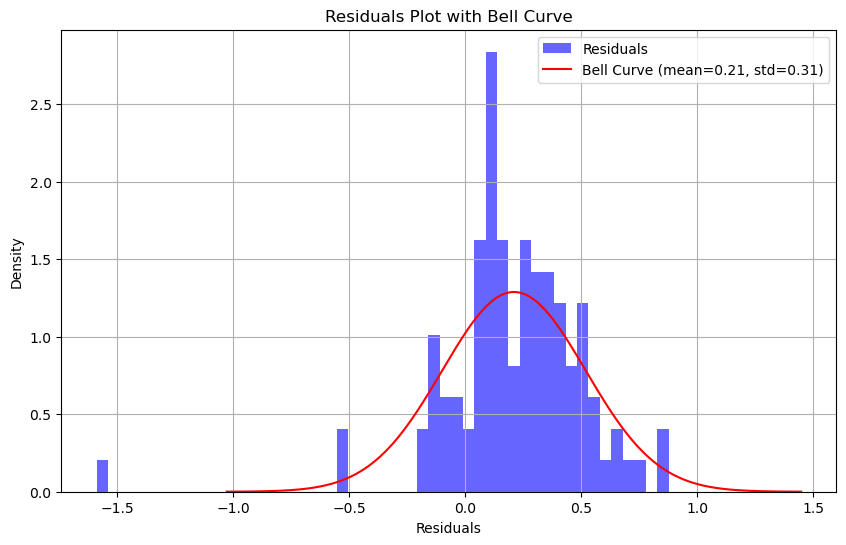

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

total_residuals = torch.cat(total_residuals).cpu().numpy()

mean_residuals = np.mean(total_residuals)
std_residuals = np.std(total_residuals)

x = np.linspace(mean_residuals - 4 * std_residuals, mean_residuals + 4 * std_residuals, 1000)
bell_curve = norm.pdf(x, mean_residuals, std_residuals)

plt.figure(figsize=(10, 6))
plt.hist(total_residuals, bins=50, density=True, alpha=0.6, color='blue', label='Residuals')
plt.plot(x, bell_curve, 'r-', label=f'Bell Curve (mean={mean_residuals:.2f}, std={std_residuals:.2f})')

# Add labels, title, and legend
plt.title('Residuals Plot with Bell Curve')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Making saliency maps for one test image

In [21]:
images = next(iter(test_data_loader))
input_tensor, labels = images["spectrogram"].to(DEVICE), images["target"].to(DEVICE)

original_image_first_channel = input_tensor[0, 0, :, :].detach().cpu().numpy()
input_tensor = input_tensor[0,:,:,:]
labels = labels[0]

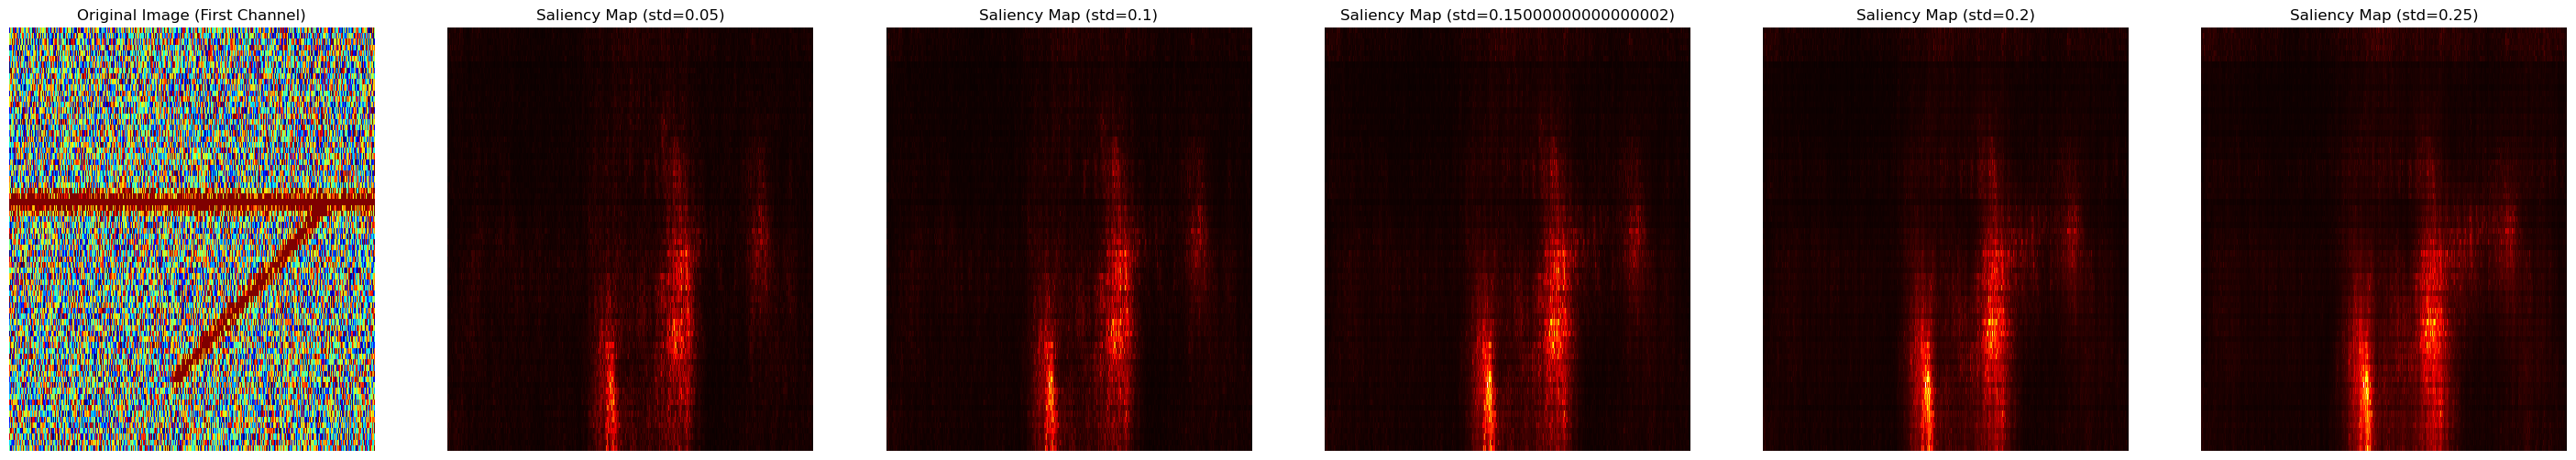

In [25]:
from saliency import smooth_grad

TS_CROPTWIDTH = (-150, 200)
VR_CROPTWIDTH = (-60, 15)

fig, axs = plt.subplots(1, 6, figsize=(36, 6))
axs[0].imshow(original_image_first_channel, aspect="auto", 
    extent=[TS_CROPTWIDTH[0]/1000,TS_CROPTWIDTH[1]/1000,
            VR_CROPTWIDTH[0],VR_CROPTWIDTH[1]],
    origin="upper",
    interpolation='nearest',
    cmap="jet")
axs[0].set_title("Original Image (First Channel)")
axs[0].axis('off')

print
for i in range(1, 6):
    std = 0.05*i
    saliency_map = smooth_grad(model, input_tensor, labels, num_samples=50, noise_level=std, device=DEVICE)

    saliency_map_reshaped = saliency_map.squeeze()

    axs[i].imshow(saliency_map_reshaped, origin='upper', aspect="auto", 
        extent=[TS_CROPTWIDTH[0]/1000,TS_CROPTWIDTH[1]/1000,
                VR_CROPTWIDTH[0],VR_CROPTWIDTH[1]],
        interpolation='nearest',
        cmap='hot')
    axs[i].set_title(f"Saliency Map (std={std})")
    axs[i].axis('off')

# plt.tight_layout()
# plt.savefig(f"plots/saliency_map_comparison_}.png", dpi=300)
plt.show()